In [1]:
cd PycharmProjects/motoki_ul/review_analysis

[Errno 2] No such file or directory: 'PycharmProjects/motoki_ul/review_analysis'
/Users/motoki/PycharmProjects/motoki_ul/review_analysis


In [33]:
##Clean raw data & prepare for analytics

import pandas as pd

input_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/input_dir/lohaco"
df = pd.read_csv(f"{input_dir}/Suppli_Review.csv")
df.fillna("。")

category = "ダイエット"
sub_category = "紅茶"
sub_category_excl = "紅茶（ペットボトル）"

#Rename columns
df.rename(columns={"380_カタログCD": "product_code",
                   "390_WEBユニーク名": "product_name",
                   "840_評価": "review",
                   "841_タイトル": "title",
                   "842_コメント": "comment",
                   "340_WEB大カテゴリ名": "category",
                   "350_WEB中カテゴリ名": "sub-category"}, inplace=True)

#Found NaN in title columns so replaced
df["combined_title"] = df["title"].fillna("。").str.cat(" " + df["comment"])
df_new_raw = pd.concat([df["product_code"], df["product_name"], df["Brand"], df["combined_title"], df["category"], df["sub-category"]], axis=1)
df_new = df_new_raw.fillna(0)
df_new = df_new[df_new["category"].str.contains(category)]
#df_new = df_new[df_new["sub-category"].str.contains(sub_category)]
# df_new = df_new[df_new["product_name"].str.contains('カフェイン')]
df_new = df_new[~df_new["sub-category"].str.contains(sub_category_excl)]
print(df_new)

#Combine comments on each product (for Doc2Vec)
df_new_combined = df_new.groupby(["product_name", "product_code", "Brand"])["combined_title"].sum().reset_index()
print(df_new_combined)

      product_code                                       product_name  \
31         4604388  【アウトレット】DHC プロティンダイエット＜ココア、いちごミルク、コーヒー牛乳＞ 1箱（7...   
34         9623297  アサヒグループ食品 リセットボディ　発芽玄米入り雑炊（5食セット） 494684263727...   
42         P072049    ぐーぴたっ しっとりクッキー ブルーベリーチーズケーキ 3本入 1セット（3箱） ナリス化粧品   
45         U219693  ファンケル 大人のカロリミット ＜機能性表示食品＞ 30回分 [サプリメント サプリ ダイエ...   
380        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
381        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
382        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
383        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
384        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
385        4604412  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...   
386        4779400  ORBIS（オルビス） プチシェイク フレッシュストロベリー 100g×7食分 ダイエットド...   
409        8363827        DHC メリロート 20日分/40粒 ダイエット・美容 ディーエイチシー サプリメント   
410        8363827        DHC メリロート 20日分/40粒 ダイエット・

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/motoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      word  count
24      効果    136
106     購入    116
42      続け     94
22     やすい     91
7       思い     84
9       飲ん     84
110      味     82
171  ダイエット     77
12      期待     64
397      n     62
6        み     62
137   美味しい     57
98      なり     50
36      なっ     48
219     食べ     44
214     商品     43
30      いい     43
157     あり     41
166     いる     39
59      良い     38
28      飲む     36
111     ある     34
5       試し     33
269   カプセル     33
118     思っ     30
268    ソフト     30
45     やすく     29
162      得     29
0       運動     28
50     わかり     28


<Figure size 2160x1440 with 0 Axes>

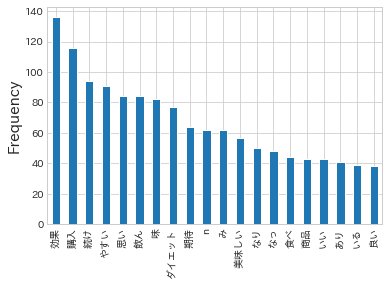

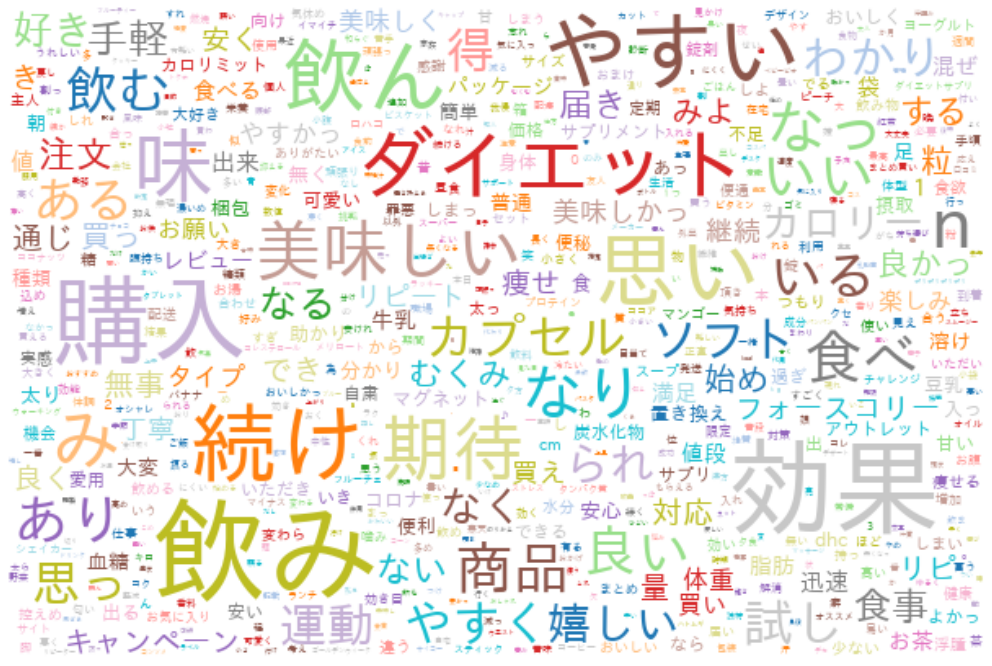

In [34]:
##Split into words and visualize

from sklearn.feature_extraction import stop_words
from collections import Counter, defaultdict
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import MeCab
import sys
import urllib
import nltk
import string
import re
import numpy as np

%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic"

tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
tagger.parse("")

class CustomMeCabTagger(MeCab.Tagger):

    COLUMNS = ["表層形", "品詞", "品詞細分類1", "品詞細分類2", "品詞細分類3", "活用型", "活用形", "原形", "読み", "発音"]

    def parseToDataFrame(self, text: str) -> pd.DataFrame:
        """テキストを parse した結果を Pandas DataFrame として返す"""
        results = []
        #Mecabの出力方式に基づく。(表層系\t品詞,品詞細分類...)
        #まずは改行で分けて単語自体を区分する
        text_unlisted = " ".join([i for item in text for i in item])
        for line in self.parse(text_unlisted).split("\n"):
            #EOS = end of statement, no more words
            if line == "EOS":
                break
            #Split word itself and feature by "tab"
            surface, feature = line.split("\t")
            #Put None if the content is "*" (means nothing)
            feature = [None if f == "*" else f for f in feature.split(",")]
            results.append([surface, *feature])
        return pd.DataFrame(results, columns=type(self).COLUMNS)

def get_dokuritsugo_by_mecab(text):
    tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
    tagger.parse("") 
    node = tagger.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        #only needs below (others don't have meanings in this context)
        if pos in ["名詞", "動詞", "形容詞"]:
            word = node.surface
            word_list.append(word)
        node = node.next
    return " ".join(word_list)

df_new["cleared_words"] = df_new["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))

stop_words_all = []
#define stopword (English)
nltk.download("stopwords")
stop_words_sklearn = stop_words.ENGLISH_STOP_WORDS
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_nltk.extend(stop_words_sklearn)
stop_words_all = stop_words_nltk

#define stopword (Japanese)
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']
stop_words_all.extend(slothlib_stopwords)

#define manual stopword
add_words=["'",u"それ",u"てる",u"よう",u"こと",u"の",u"し",u"い",u"ん",u"さ",u"て",u"せ",u"れ"]
stop_words_all.extend(add_words)

def del_stop_words(text):
    #replace all the punctuations by using re.sub()
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    sample = regex.sub("", text)
    
    #change to lower case and check if it's in stop words list
    words = [w.lower()  for w in sample.split(" ") \
                 if not w.lower()  in stop_words_all]
    words=" ".join(words)
    return words

def del_single_used_words(text):
    #delete words only used once
    frequency = defaultdict(int)
    for words in text:
        for token in words:
            frequency[token] += 1
    words = [[token for token in words if frequency[token] > 1] for words in text]
    return words

df_new["cleared_stopwords"] = list(df_new["cleared_words"].apply(lambda x: del_stop_words(x)))
text = del_single_used_words([i.split(" ") for i in df_new["cleared_stopwords"]])

##Make combined list for doc2vec (now also used for LDA&word2Vec)
df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"]=list(df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x)))
text_combined = del_single_used_words([i.split(" ") for i in df_new_combined["cleared_stopwords"]])

#finally make dataframe of wordlist splitted by MeCab
tagger = CustomMeCabTagger()
result = tagger.parseToDataFrame(text_combined)

counter_list = []
for i in result["表層形"]:
    counter_list.append(i)
word_count = Counter(counter_list)

df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count = df_count.iloc[1:,:]

print(df_count.head(30))

#Visualization for word count graph
plt.figure(figsize = (30,20))
ax=df_count.iloc[:20,:].plot.bar()
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xticklabels(
    df_count.iloc[:20,:]["word"], fontdict = {
        'fontsize':10})
ax.legend_.remove()
plt.style.use('seaborn-whitegrid')
plt.show()

fpath = "/Users/motoki/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
#Visualization for word cloud
wc_bz = WordCloud(
    background_color="white",
    width=600,
    height=400,
    max_words=3000,
    max_font_size=70,
    font_path=fpath,
    prefer_horizontal=1,
    include_numbers=True,
    colormap='tab20',
    regexp=r"[\w']+")
wc_bz.generate_from_frequencies(word_count)

plt.figure(figsize = (21,12))
#sns.set_style("whitegrid")
plt.imshow(wc_bz, interpolation="bilinear")
plt.axis("off")
plt.style.use('seaborn-whitegrid')
plt.show()

In [35]:
# word frequency output to csv

import datetime

now = datetime.datetime.today()
today = now.strftime("%Y%m%d")

output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/lohaco"
filename = f"{today}_{category}_review.csv"
df_count.to_csv(f"{output_dir}/{filename}")

df_count

word  count
24          効果    136
106         購入    116
42          続け     94
22         やすい     91
7           思い     84
9           飲ん     84
110          味     82
171      ダイエット     77
12          期待     64
397          n     62
6            み     62
137       美味しい     57
98          なり     50
36          なっ     48
219         食べ     44
214         商品     43
30          いい     43
157         あり     41
166         いる     39
59          良い     38
28          飲む     36
111         ある     34
5           試し     33
269       カプセル     33
118         思っ     30
268        ソフト     30
45         やすく     29
162          得     29
0           運動     28
50         わかり     28
119         られ     27
52         嬉しい     26
146         なく     24
183         手軽     22
196       カロリー     22
174         好き     22
82          なる     21
107         食事     20
77          注文     20
71          ない     19
490         届き     18
310        むくみ     18
133         する     18
75          みよ     17
41           粒     17
46          始め     17
99         良かっ     17
518         対応     16
4            き     16
515         無事     16
97          でき     16
165         通じ     16
242         買っ     16
270    フォースコリー     15
350          量     15
68          良く     15
134         安く     15
158         リピ     15
160     キャンペーン     15
64          痩せ     15
126         継続     14
488      美味しかっ     14
25        リピート     14
179         買え     14
517         丁寧     14
116        タイプ     13
130       美味しく     13
23        やすかっ     13
2           体重     13
413          １     12
215         買い     12
103          値     12
521        お願い     12
180         出来     12
516         迅速     12
49         楽しみ     12
394         満足     11
194        食べる     11
385         混ぜ     11
39          値段     11
322          袋     11
383         牛乳     11
104         お茶     11
178       レビュー     11
10          脂肪     11
43       パッケージ     10
121         溶け     10
61          太り     10
188         安心     10
102         血糖     10
129         普通     10
358         大変     10
361         無く     10
417          足     10
44         分かり     10
384         豆乳      9
60         コロナ      9
410          食      9
212         身体      9
487         種類      9
170         甘い      9
634      マグネット      9
65         dhc      9
173         便利      9
642         梱包      9
144        助かり      9
405       置き換え      9
349         入っ      9
31           朝      9
618        可愛い      9
182         出る      9
96          摂取      9
95          簡単      9
485       おいしく      9
27          便秘      8
282         向け      8
304         愛用      8
520       いただき      8
290        しまっ      8
187       炭水化物      8
181         自粛      8
29           出      8
161         あっ      8
177         安い      8
184        できる      8
185         いき      8
274        よかっ      8
168         価格      8
1           不足      8
14      サプリメント      8
220         過ぎ      8
15         サプリ      8
480     アウトレット      8
277         から      8
599     カロリミット      8
240         なら      8
235         定期      7
159         実感      7
34          水分      7
222         食欲      7
416         浮腫      7
263        痩せる      7
90         つもり      7
72         少ない      7
289         太っ      7
278         cm      7
200         錠剤      7
330         機会      7
272         違う      7
207          糖      7
117         しよ      7
424        しまい      7
189        大好き      7
210          し      7
522          甘      7
32           錠      6
489       おいしい      6
267        サイズ      6
17         変わら      6
13          でる      6
232         効い      6
37          便通      6
494      ヨーグルト      6
198         罪悪      6
199          昔      6
244         使い      6
467        スープ      6
466         お湯      6
643         配送      6
247          本      6
108        飲み物      6
375          箱      6
411          。      6
112         健康      6
523        控えめ      6
291         主人      6
402       マンゴー      6
147        飲める      6
519         感謝      6
329         届い      5
380      お気に入り      5
63    

In [21]:
##TF-IDF analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"] = df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x))
text_combined_tfidf = [i for i in df_new_combined["cleared_stopwords"]]

vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(text_combined_tfidf)
X=X.toarray()

idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
df_idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
df_idf.columns = ['idf']
display(df_idf.sort_values("idf").head(10).T)

購入      美味しい        飲み       やすい        思い        飲ん       良い  \
idf  1.832088  1.947986  2.004646  2.069484  2.123551  2.196883  2.27602   

           いる        いい        あり  
idf  2.361962  2.374866  2.387938

In [22]:
##t-SNE for TF-IDF
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, verbose=1, n_iter=500)
tsne_tfidf = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 608 samples in 0.095s...
[t-SNE] Computed neighbors for 608 samples in 2.174s...
[t-SNE] Computed conditional probabilities for sample 608 / 608
[t-SNE] Mean sigma: 0.294841
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.107285
[t-SNE] KL divergence after 500 iterations: 1.539114


In [23]:
#Put in DataFrame
df_tsne = pd.DataFrame(tsne_tfidf[:,0],columns = ["x"])
df_tsne["y"] = pd.DataFrame(tsne_tfidf[:,1])
df_tsne["product_name"]=df_new_combined.product_name  
df_tsne["brand"]=df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne.head(10))

x          y                                  product_name  \
0  12.540310   0.864001               1日堅果ミックス　オリジナル　1箱（15袋入）　3G　CARE   
1  -0.187762 -12.481075                1日堅果ミックス　スイート　1箱（15袋入）　3G　CARE   
2   8.438711 -10.780994      1本満足バー チーズタルト 1セット（18本） アサヒグループ食品 栄養調整食品   
3  15.025113  -3.495428  1本満足バー プロテインブラック 36本 アサヒグループ食品 栄養調整食品 一本満足バー   
4  -1.819978   6.310493   1本満足バー プロテインブラック 9本 アサヒグループ食品 栄養調整食品 一本満足バー   
5   8.478471 -10.797771  1本満足バー プロテイン・ラン ベイクドバナナ 36本 アサヒグループ食品 栄養調整食品   
6  21.786179   0.381463     1本満足バー ヘルシー焼きショコラ プレーン 1セット（9本） アサヒグループ食品   
7  16.087540   0.138747                3GCARE ハニーバターアーモンドキャラメル 28g 3袋   
8  -8.895584  25.538599     C1000 ビタミンレモン 1パック（6本） ハウスウェルネスフーズ 栄養ドリンク   
9   1.140079   0.778371    C1000 ビタミンレモン 2パック（12本） ハウスウェルネスフーズ 栄養ドリンク   

               brand  
0           1日堅果ミックス  
1           1日堅果ミックス  
2             1本満足バー  
3             1本満足バー  
4             1本満足バー  
5             1本満足バー  
6             1本満足バー  
7  3G CARE（スリージーケアー）  
8        C1000（シーセン）  
9        C1000（シーセン）

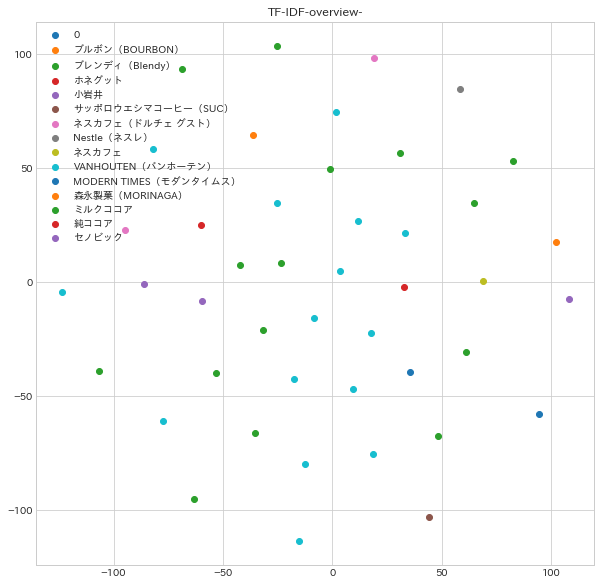

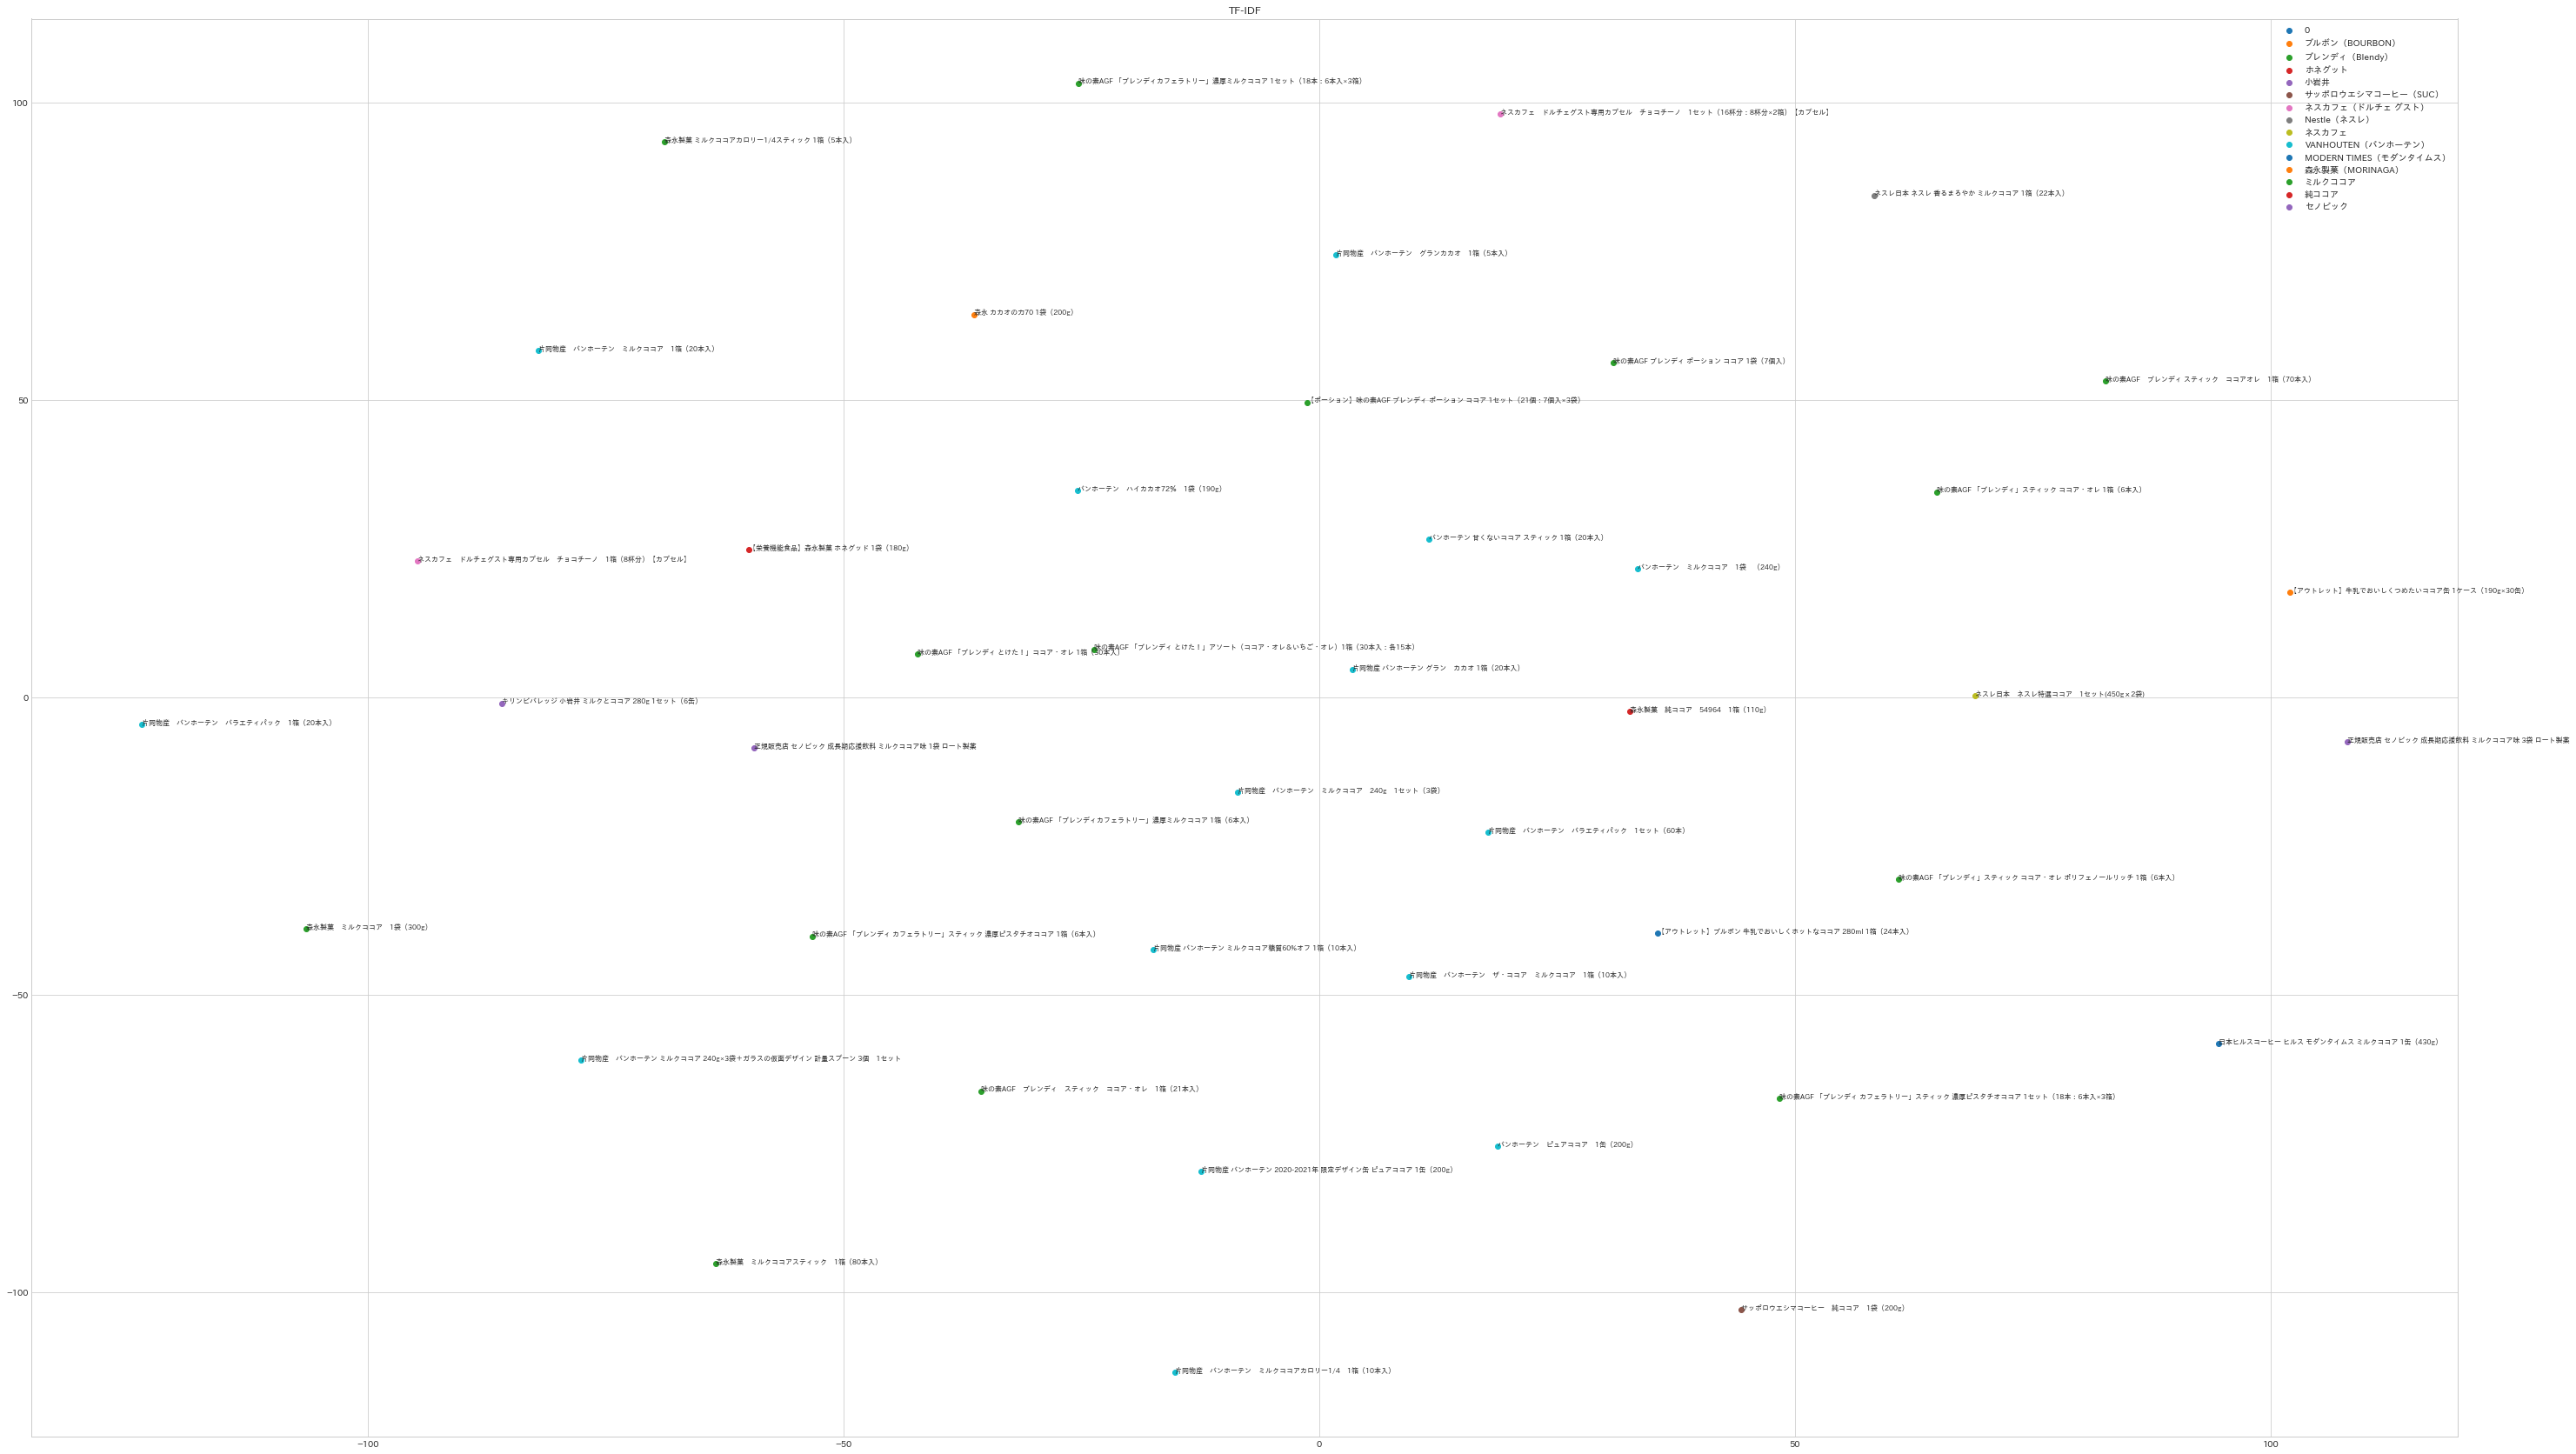

In [8]:
##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

plt.legend()
plt.title("TF-IDF-overview-")
plt.show()

#B: Detail
fig_detail = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne["product_name"].values):
    plt.annotate(txt, (df_tsne["x"].values[i], df_tsne["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("TF-IDF")
plt.show()

In [42]:
##LDA analytics (after filtering TF-IDF)

import gensim
from gensim import corpora, models

#Dictionary is the set of "word ID, word, frequency" data (can be saved)
dictionary =corpora.Dictionary(text)
corpus = [dictionary.doc2bow(doc) for doc in text_combined]

#Can filter TF-IDF before LDA
#TF = Term Frequency -> frequency of each word (the bigger, the more important)
#IDF = Inverse document frequency -> filtering too high frequent words like "a, the, there etc.."
#Below is the class for TF-IDF analytics
#tfidf = gensim.models.TfidfModel(corpus)
#corpus_tfidf = tfidf[corpus]

#Number of topics
zk = 4
#Learning model (can be saved)
lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=zk, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000)

for i in range(zk):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)[0:80]+'...'))

tpc_0: 0.099*"" + 0.068*"n" + 0.038*"商品" + 0.021*"対応" + 0.021*"無事" + 0.020*"注文" + 0.019...
tpc_1: 0.051*"飲み" + 0.040*"効果" + 0.028*"購入" + 0.027*"やすい" + 0.027*"続け" + 0.022*"思い" + 0...
tpc_2: 0.050*"" + 0.038*"味" + 0.023*"購入" + 0.019*"美味しい" + 0.015*"飲ん" + 0.014*"あり" + 0.0...
tpc_3: 0.045*"美味しい" + 0.034*"食べ" + 0.025*"味" + 0.023*"" + 0.023*"ダイエット" + 0.015*"なり" + ...


product_name    Prob_1    Prob_2  \
0           DHC αーリポ酸 60日分/120粒 ダイエット ディーエイチシー サプリメント  0.011599  0.964579   
1   DHC ウエスト気になる 20日分/40粒 ダイエット・体脂肪・中性脂肪 ディーエイチシー ...  0.001837  0.994610   
2     DHC カラダ対策茶W 20日分 ダイエット お茶・スティック ディーエイチシー【機能性食品】  0.001977  0.970105   
3          DHC ガルシニアエキス 20日分×3袋 ダイエット ディーエイチシー サプリメント  0.012190  0.962965   
4              DHC キトサン 20日分×3袋 ダイエット ディーエイチシー サプリメント  0.031725  0.905328   
5                 DHC ギムネマ 20日分 ダイエット ディーエイチシー サプリメント  0.001351  0.995919   
6              DHC ギムネマ 20日分×3袋 ダイエット ディーエイチシー サプリメント  0.009444  0.009372   
7   DHC ダイエットパワー 20日分 ダイエット・カルニチン・αリポ酸 ディーエイチシー サプ...  0.005389  0.005741   
8   DHC ダイエットパワー 20日分×3袋 ダイエット・カルニチン・αリポ酸 ディーエイチシー...  0.027830  0.913945   
9                     DHC デトクレンズ＜サプリメント＞1セット（20日分×2袋）  0.031782  0.033767   
10  DHC フォースコリー 20～40日分/80粒 ダイエット・ビタミンB ディーエイチシー サ...  0.006946  0.978414   
11                           DHC フォースコリー20日 ビタミンC付 1袋  0.014917  0.955279   
12                           DHC フォースコリー20日 ビタミンC付 2袋  0.032046  0.036460   
13  DHC フォースコリーソフトカプセル 20～40日分/40粒 ダイエット・美容・ココナッツ ...  0.000217  0.999345   
14  DHC フォースコリーソフトカプセル 20～40日分/40粒×3袋 ダイエット・美容・ココナ...  0.011417  0.966074   
15  DHC プロティンダイエット 美Body チョコ味 スムージー MCTオイル・乳酸菌・ビタミ...  0.009921  0.082631   
16  DHC プロティンダイエット 美Body バナナ味 スムージー MCTオイル・乳酸菌・ビタミ...  0.009392  0.234963   
17  DHC プロティンダイエット 美Body バナナ味×2個 スムージー MCTオイル・乳酸菌・...  0.710300  0.232701   
18  DHC プロティンダイエット 美Body マンゴー味 スムージー MCTオイル・乳酸菌・ビタ...  0.002973  0.003010   
19        DHC メリロート 20日分/40粒 ダイエット・美容 ディーエイチシー サプリメント  0.000795  0.997613   
20     DHC メリロート 20日分/40粒×3袋 ダイエット・美容 ディーエイチシー サプリメント  0.012602  0.961877   
21                         DHC 善玉菌ダイエット 1セット（20日分×3袋）  0.025083  0.922787   
22  DHC 血糖ファイバー 20包 ダイエット・食物繊維 スティック・粉 ディーエイチシー サプ...  0.001659  0.886769   
23                      DHC　プロティンダイエット スープパスタ　1箱（7食入）  0.002302  0.002351   
24  ORBIS（オルビス） プチシェイク グレープフルーツ&レモン 100g×7食分 ダイエット...  0.014246  0.229958   
25  ORBIS（オルビス） プチシェイク トライアルセット スウィートテイスト ダイエットドリン...  0.008492  0.008674   
26  ORBIS（オルビス） プチシェイク トライアルセット リフレッシングテイスト ダイエットド...  0.008174  0.008317   
27  ORBIS（オルビス） プチシェイク パイン&マンゴー 100g×7食分 ダイエットドリンク...  0.006780  0.006582   
28  ORBIS（オルビス） プチシェイク フルーティーベリー 100g×7食分 ダイエットドリン...  0.516710  0.031816   
29  ORBIS（オルビス） プチシェイク フレッシュストロベリー 100g×7食分 ダイエットド...  0.007236  0.007487   

      Prob_3    Prob_4  Max  
0   0.012096  0.011727    2  
1   0.001777  0.001776    2  
2   0.002057  0.025862    2  
3   0.012788  0.012057    2  
4   0.031607  0.031340    2  
5   0.001369  0.001361    2  
6   0.971880  0.009304    3  
7   0.983461  0.005409    3  
8   0.030281  0.027944    2  
9   0.901721  0.032730    3  
10  0.007681  0.006959    2  
11  0.014909  0.014895    2  
12  0.503366  0.428128    3  
13  0.000219  0.000218    2  
14  0.011368  0.011141    2  
15  0.897151  0.010298    3  
16  0.746324  0.009321    3  
17  0.006188  0.050811    1  
18  0.991020  0.002998    3  
19  0.000799  0.000792    2  
20  0.012780  0.012741    2  
21  0.027021  0.025108    2  
22  0.001696  0.109876    2  
23  0.002344  0.993003    4  
24  0.740815  0.014981    3  
25  0.008411  0.974424    4  
26  0.008346  0.975163    4  
27  0.979620  0.007017    3  
28  0.032511  0.418962    1  
29  0.099825  0.885452    4

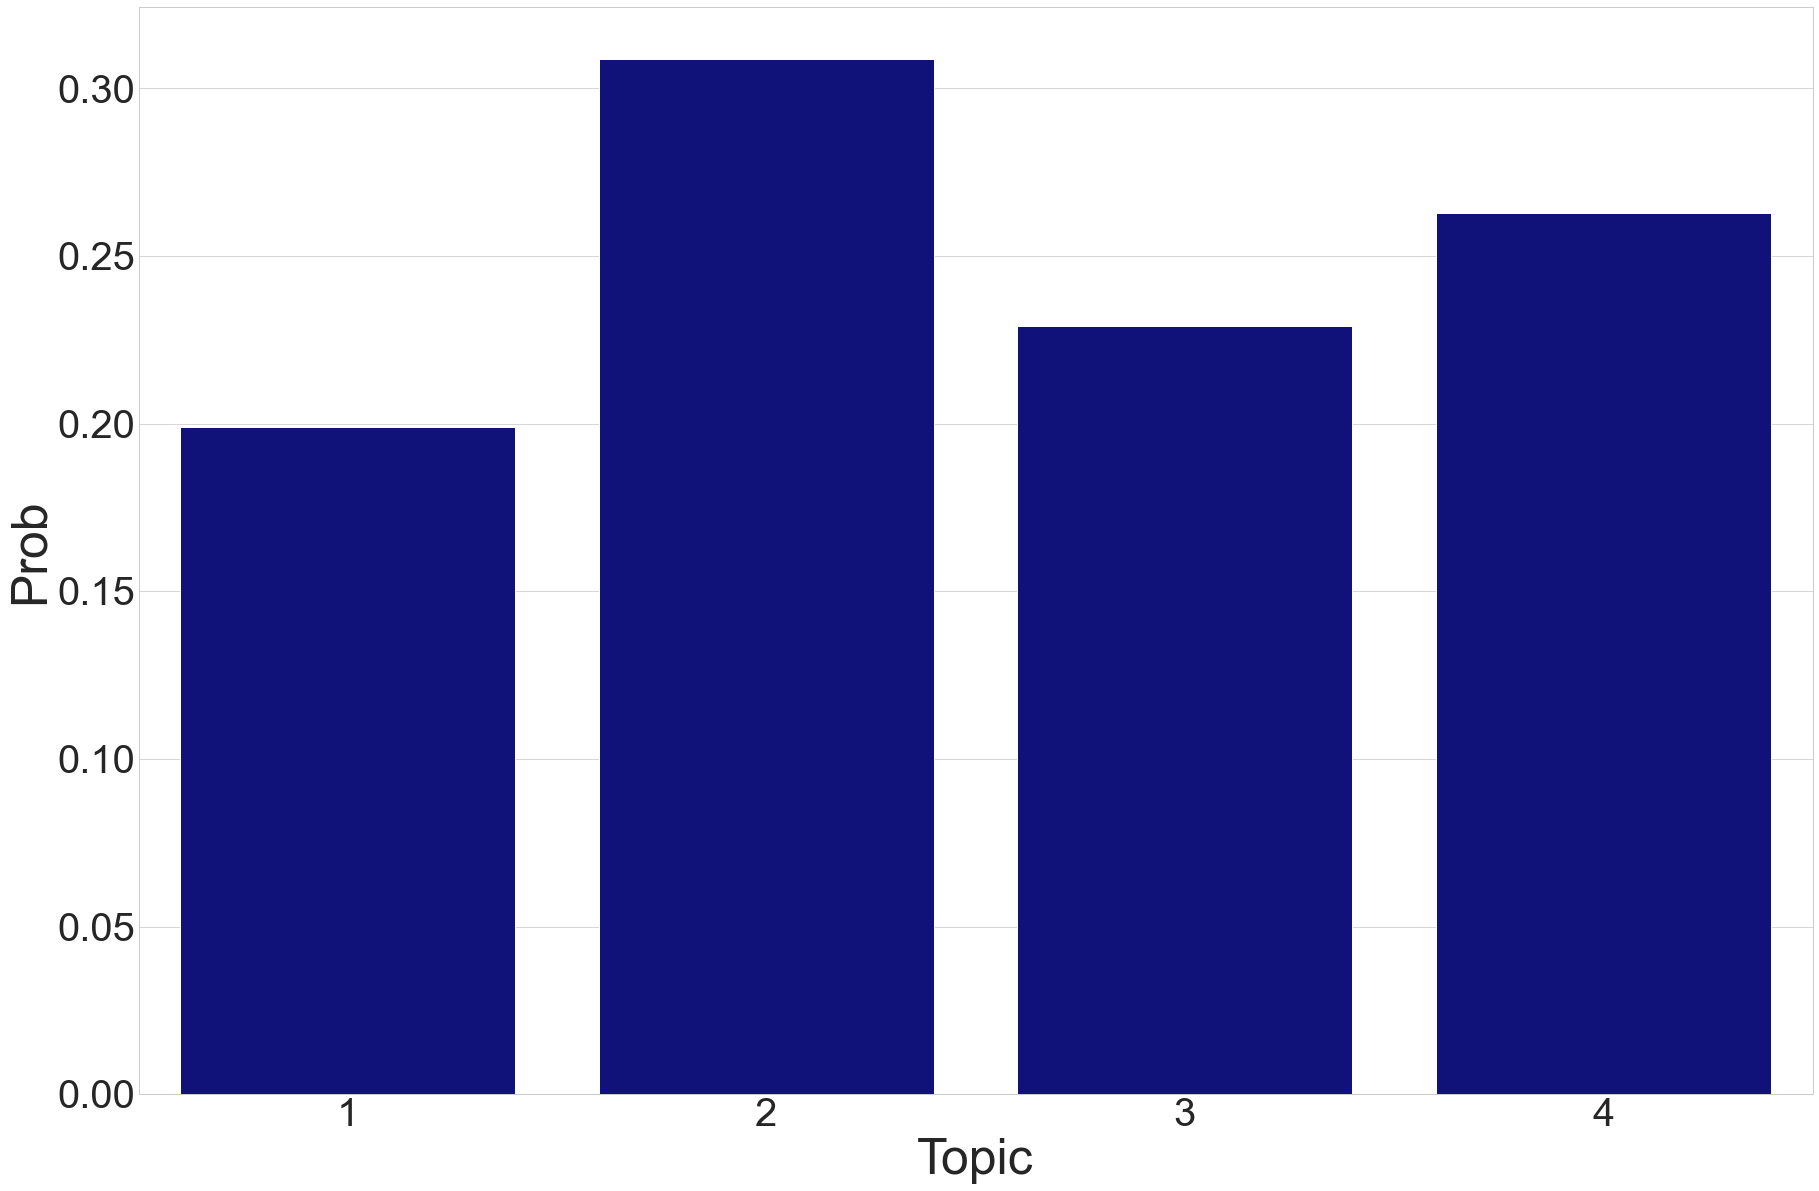

In [43]:
#Make Numpy b/w Products & topics
Prob_products=np.array(lda.get_document_topics(corpus,minimum_probability=0))[:,:,1]

#Put in DataFrame
L=[ z for z in range(1,zk+1)]
col_name=list(map(lambda x: "Prob_"+str(x),L))
df_prob=pd.DataFrame(Prob_products)
df_prob.columns=col_name

#Add product name & most likely belonging topic No.
df_prob["Max"]=df_prob.idxmax(axis=1)
def del_Prob(x):
    return int(x.split("_")[1])
df_prob["Max"]=df_prob["Max"].apply(lambda x : del_Prob(x))
df_prob.insert(0, "product_name", df_new_combined["product_name"])
display(df_prob.head(30))

#Calculate probability of apperance of each topic
df_topic=pd.DataFrame(df_prob.drop(["Max", "product_name"],axis=1).sum()/df_prob.drop(["Max", "product_name"],axis=1).sum().sum())
df_topic.columns=["Prob"]
df_topic["Topic"]=[ z for z in range(1,zk+1)]

#Visualization
plt.figure(figsize = (30,20))
ax= sns.barplot(x="Topic",y="Prob",data=df_topic,color="darkblue")
ax.set_xlabel("Topic",fontsize=50)
ax.set_ylabel("Prob",fontsize=50)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
plt.show()

<Figure size 1512x864 with 0 Axes>

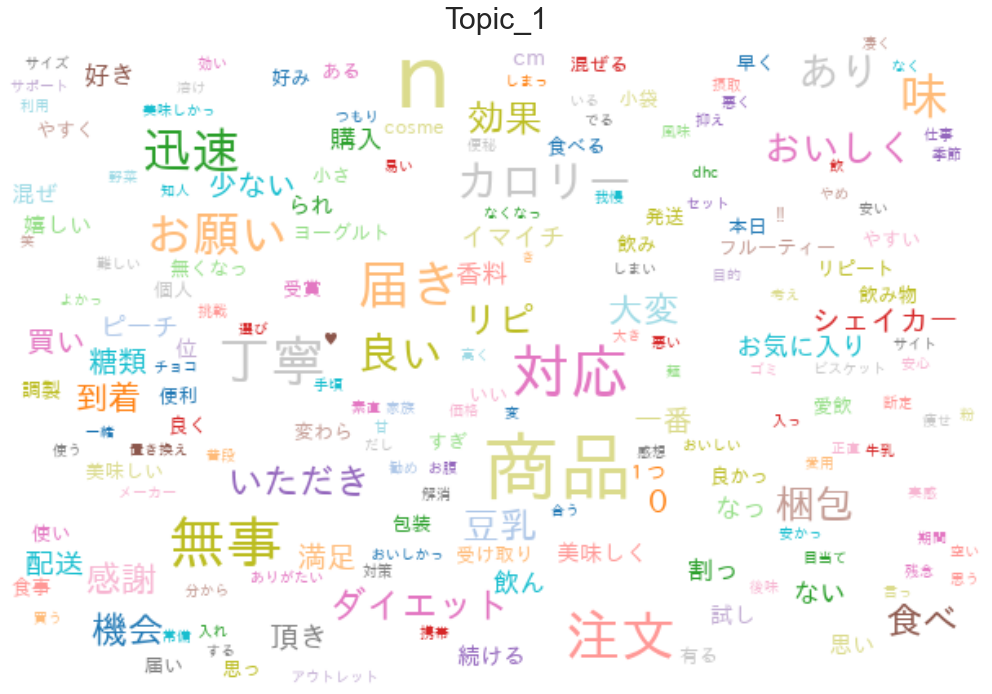

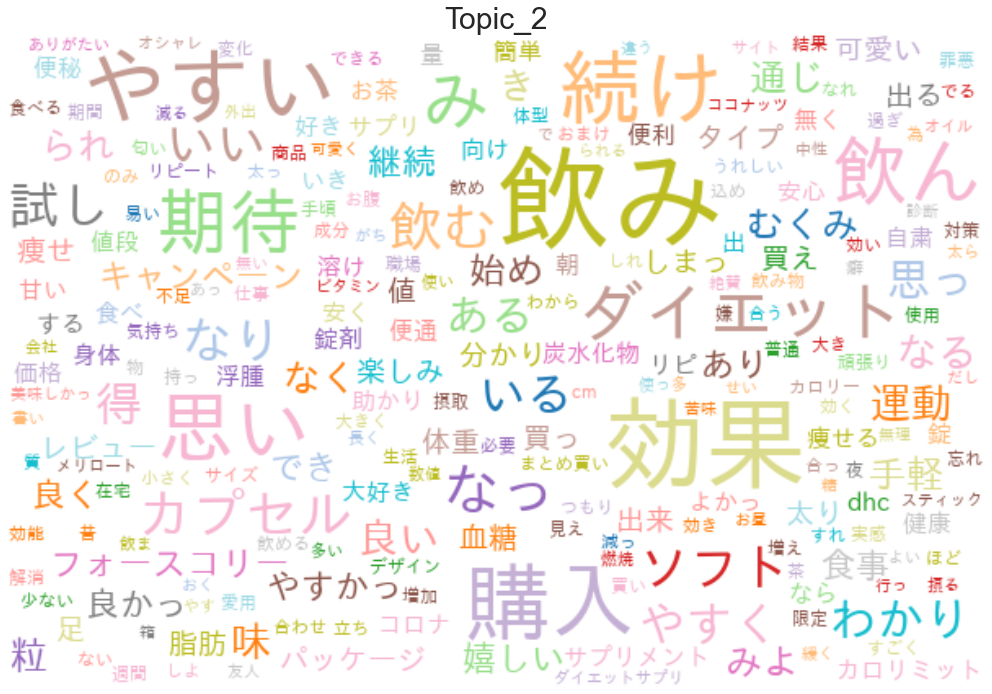

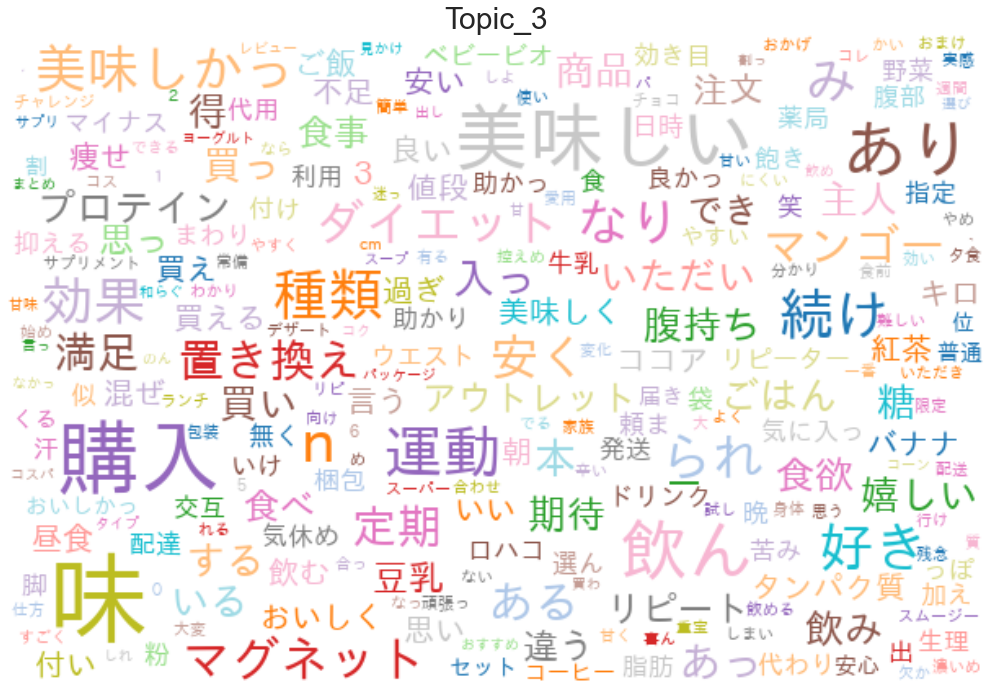

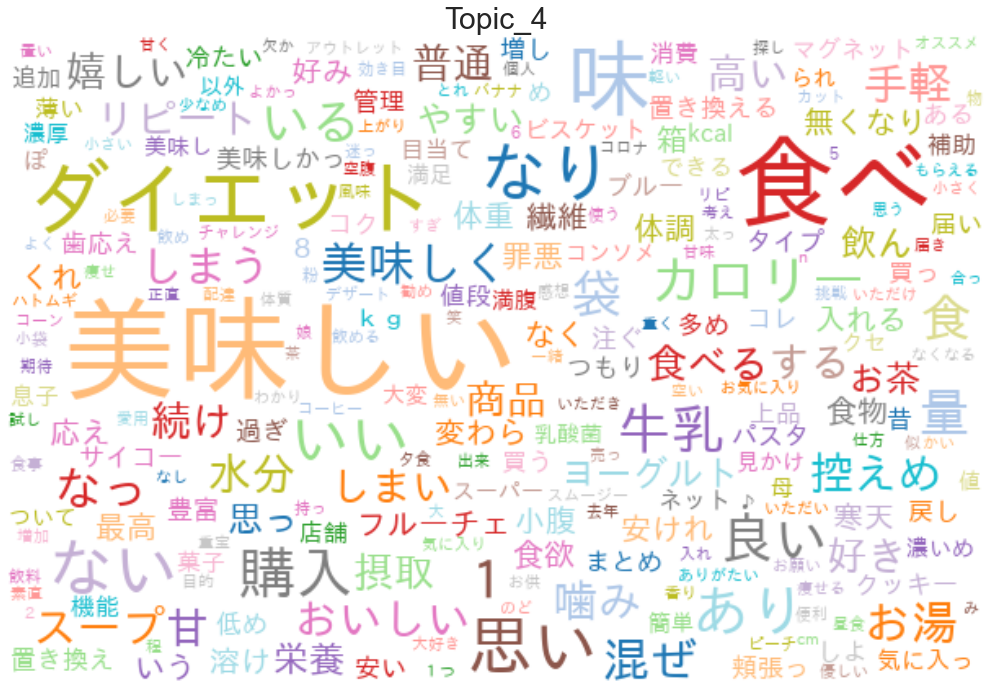

In [44]:
##Visualization of words

topic_word_prob=[]

for z in range(zk):
    word=[]
    prob=[]
    topic = lda.show_topic(z,1000) #No. of words

    for t in topic:
        word.append(t[0])
        prob.append(t[1])
        
    df_lda=pd.DataFrame({"word":word,"prob":prob})
    topic_word_prob.append(df_lda)

fig = plt.figure(figsize=(21, 12))

for z in range(zk):
    topic_text=[]
    for index, row in topic_word_prob[z].iloc[:2000,].iterrows():
        word=row["word"]
        weight=int(row["prob"]*1000)
        for _ in range(weight):
            topic_text.append(word)
            
    words = Counter(topic_text)
    wc_bz = WordCloud(background_color="white",
                      width=600, 
                      height=400, 
                      max_words=3000, 
                      max_font_size=70, 
                      font_path=fpath,
                      prefer_horizontal=1,
                      include_numbers=True,
                      colormap='tab20',
                      regexp=r"[\w']+")
    wc_bz.generate_from_frequencies(words)

    plt.figure(figsize = (21,12))
    sns.set_style("whitegrid")
    plt.title('Topic_{}'.format(z+1), fontsize=30)
    plt.imshow(wc_bz, interpolation='bilinear')
    plt.axis("off")
    
    # topic groups output to png
    output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/lohaco"
    pngname =  f"{today}_{category}_{zk}topics"
    plt.savefig(f'{output_dir}/{pngname}_{z+1}.png')
    plt.show()

In [15]:
##Word2Vec Analysis
from gensim.models import word2vec

sent = text_combined
#Learning word2vec model
model = word2vec.Word2Vec(sent,
                          vector_size=50,  # Demention of vector (depends on the number of unique words)
                          min_count=2,  # Words appearing at least 2 times
                          window=5,  # Width of window
                          epochs=4000,  # Iter numbers of leaning
                          seed=2018 # Fix seed for generating stable random number
                         )

In [14]:
word = "パケ"
# Output the most similar words & similarity index
results = model.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_パケ_


0         1         2         3         4         5         6   \
Word      かわいい         急        たま        市販      ジュース      スーパー         缶   
Sim   0.894524  0.546601  0.445977  0.422302  0.342099  0.335075  0.332907   

            7        8         9         10        11        12        13  \
Word        ダマ       強く      スプーン        感覚        思う        多い        買わ   
Sim   0.309669  0.29685  0.283961  0.282412  0.264009  0.261533  0.257278   

            14        15        16        17        18        19  
Word        買い       すごく        ない        なし       合わせ       気持ち  
Sim   0.252784  0.243827  0.243084  0.239148  0.239138  0.236598

In [50]:
## Plus/Minus words and show the similarities
results = model.wv.most_similar(positive=[u"ルイボス",u"美味しい"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2         3         4         5         6   \
Word        子供   ルイボスティー        飲み       少なく         母       バニラ        健康   
Sim   0.491984  0.428961  0.363454  0.339553  0.327391  0.296987  0.286571   

            7         8         9         10        11       12        13  \
Word        なる         １       酸っぱ        入っ        いる   ルイボスティ       口コミ   
Sim   0.282587  0.280377  0.276089  0.261365  0.254071  0.25315  0.239916   

            14        15        16       17        18        19  
Word        でき        思い        水筒       種類        注ぐ        作る  
Sim   0.239635  0.230769  0.228517  0.21024  0.207163  0.206145

In [16]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.product_name[i])
    feature_vec = np.zeros(50)
    num_words = 0
    for word in product:
        try:
            feature_vec += model.wv[word]
            num_words += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec = feature_vec / num_words  # Split sum of all the words vector
    product_vec[i] = feature_vec

##t-SNE for Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_word2vec = tsne.fit_transform(product_vec)

1ヵ月たっぷりうるおうプラセンタCゼリー アセロラ味 10gx31本 アース製薬
AFC（エーエフシー） ハートフルシリーズ 作るヘム鉄 30日分（60粒）×2袋セット サプリメント
AFC（エーエフシー） ハートフルシリーズ 呑むウコン 1袋 サプリメント
AFC（エーエフシー） ハートフルシリーズ 流す納豆キナーゼ 30日分 60粒 サプリメント
AFC（エーエフシー） ハートフルシリーズ 消える柿渋エキス＆シャンピニオン 15日分 45粒 サプリメント
AFC（エーエフシー） ハートフルシリーズ 潤うヒアルロン酸 30日分 120粒 サプリメント
BEAUPOWERプラセンタコラーゲンゼリー  1箱（32本入） 常盤薬品工業 サプリメント
BEAUPOWERプラセンタコラーゲンゼリー 1箱（32本入）×3箱セット 常盤薬品工業 サプリメント
DHC DHA 510mg 20日分 ダイエット・記憶力・EPA ディーエイチシー サプリメント【機能性表示食品】
DHC DHA 510mg 60日分 ダイエット・記憶力・EPA ディーエイチシー サプリメント【機能性表示食品】
DHC DHA 510mg 60日分×2袋 ダイエット・記憶力・EPA ディーエイチシー サプリメント【機能性表示食品】
DHC EPA 350mg 20日分 ダイエット・記憶力・DHA ディーエイチシー サプリメント【機能性食品】
DHC EPA 350mg 20日分×3袋 ダイエット・記憶力・DHA ディーエイチシー サプリメント【機能性食品】
DHC EPA 350mg 20日分×7袋 ダイエット・記憶力・DHA ディーエイチシー サプリメント【機能性食品】
DHC はとむぎエキス 20日分/20粒 美容・ビタミンE ディーエイチシー サプリメント
DHC はとむぎエキス 20日分/20粒×3袋 美容・ビタミンE ディーエイチシー サプリメント
DHC はとむぎエキス 60日分/60粒 美容・ビタミンE ディーエイチシー サプリメント
DHC はとむぎエキス 60日分/60粒×2袋 美容・ビタミンE ディーエイチシー サプリメント
DHC アスタキサンチン 20日分/20粒 ディーエイチシー サプリメント
DHC アスタキサンチン 20日分/20粒×3袋 ディーエイチシー サプリメント
D

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 527 samples in 0.002s...
[t-SNE] Computed neighbors for 527 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 527 / 527
[t-SNE] Mean sigma: 3.045303
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.323166
[t-SNE] KL divergence after 500 iterations: 1.345971


x          y                                       product_name  \
0   5.530001  -9.914550           1ヵ月たっぷりうるおうプラセンタCゼリー アセロラ味 10gx31本 アース製薬   
1   4.987665  -0.808444  AFC（エーエフシー） ハートフルシリーズ 作るヘム鉄 30日分（60粒）×2袋セット サプ...   
2   2.353231   0.736125              AFC（エーエフシー） ハートフルシリーズ 呑むウコン 1袋 サプリメント   
3 -11.585096  -3.826683     AFC（エーエフシー） ハートフルシリーズ 流す納豆キナーゼ 30日分 60粒 サプリメント   
4   7.851512   4.771911  AFC（エーエフシー） ハートフルシリーズ 消える柿渋エキス＆シャンピニオン 15日分 45...   
5   9.089871  12.324029    AFC（エーエフシー） ハートフルシリーズ 潤うヒアルロン酸 30日分 120粒 サプリメント   
6   5.213655 -18.299437     BEAUPOWERプラセンタコラーゲンゼリー  1箱（32本入） 常盤薬品工業 サプリメント   
7 -10.983073   4.800236  BEAUPOWERプラセンタコラーゲンゼリー 1箱（32本入）×3箱セット 常盤薬品工業 サ...   
8   4.560763   9.742506  DHC DHA 510mg 20日分 ダイエット・記憶力・EPA ディーエイチシー サプリメ...   
9   4.481687   9.669462  DHC DHA 510mg 60日分 ダイエット・記憶力・EPA ディーエイチシー サプリメ...   

               brand  
0              アース製薬  
1        AFC（エーエフシー）  
2        AFC（エーエフシー）  
3        AFC（エーエフシー）  
4        AFC（エーエフシー）  
5        AFC（エーエフシー）  
6  BEAUPOWER（ビューパワー）  
7  BEAUPOWER（ビューパワー）  
8      DHC（ディーエイチシー）  
9      DHC（ディーエイチシー）

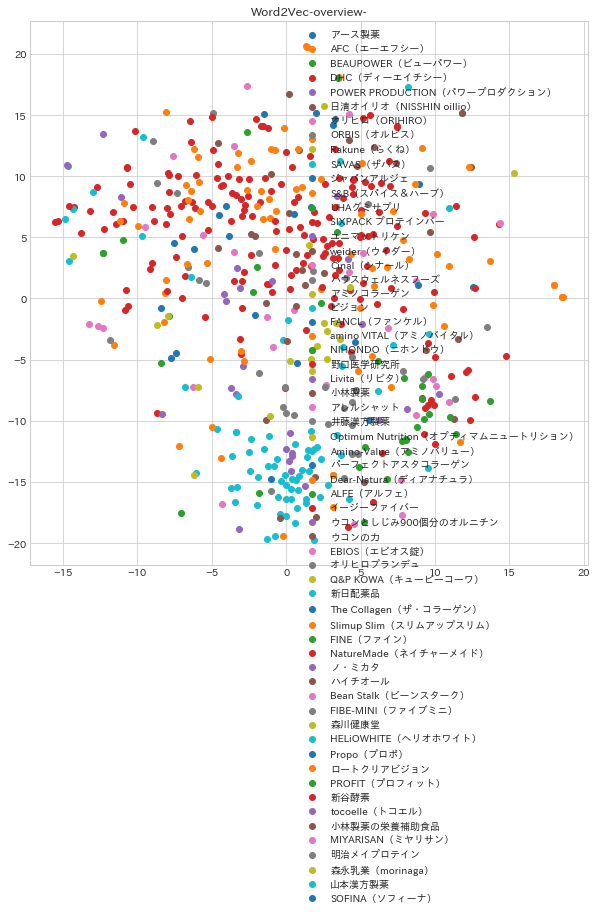

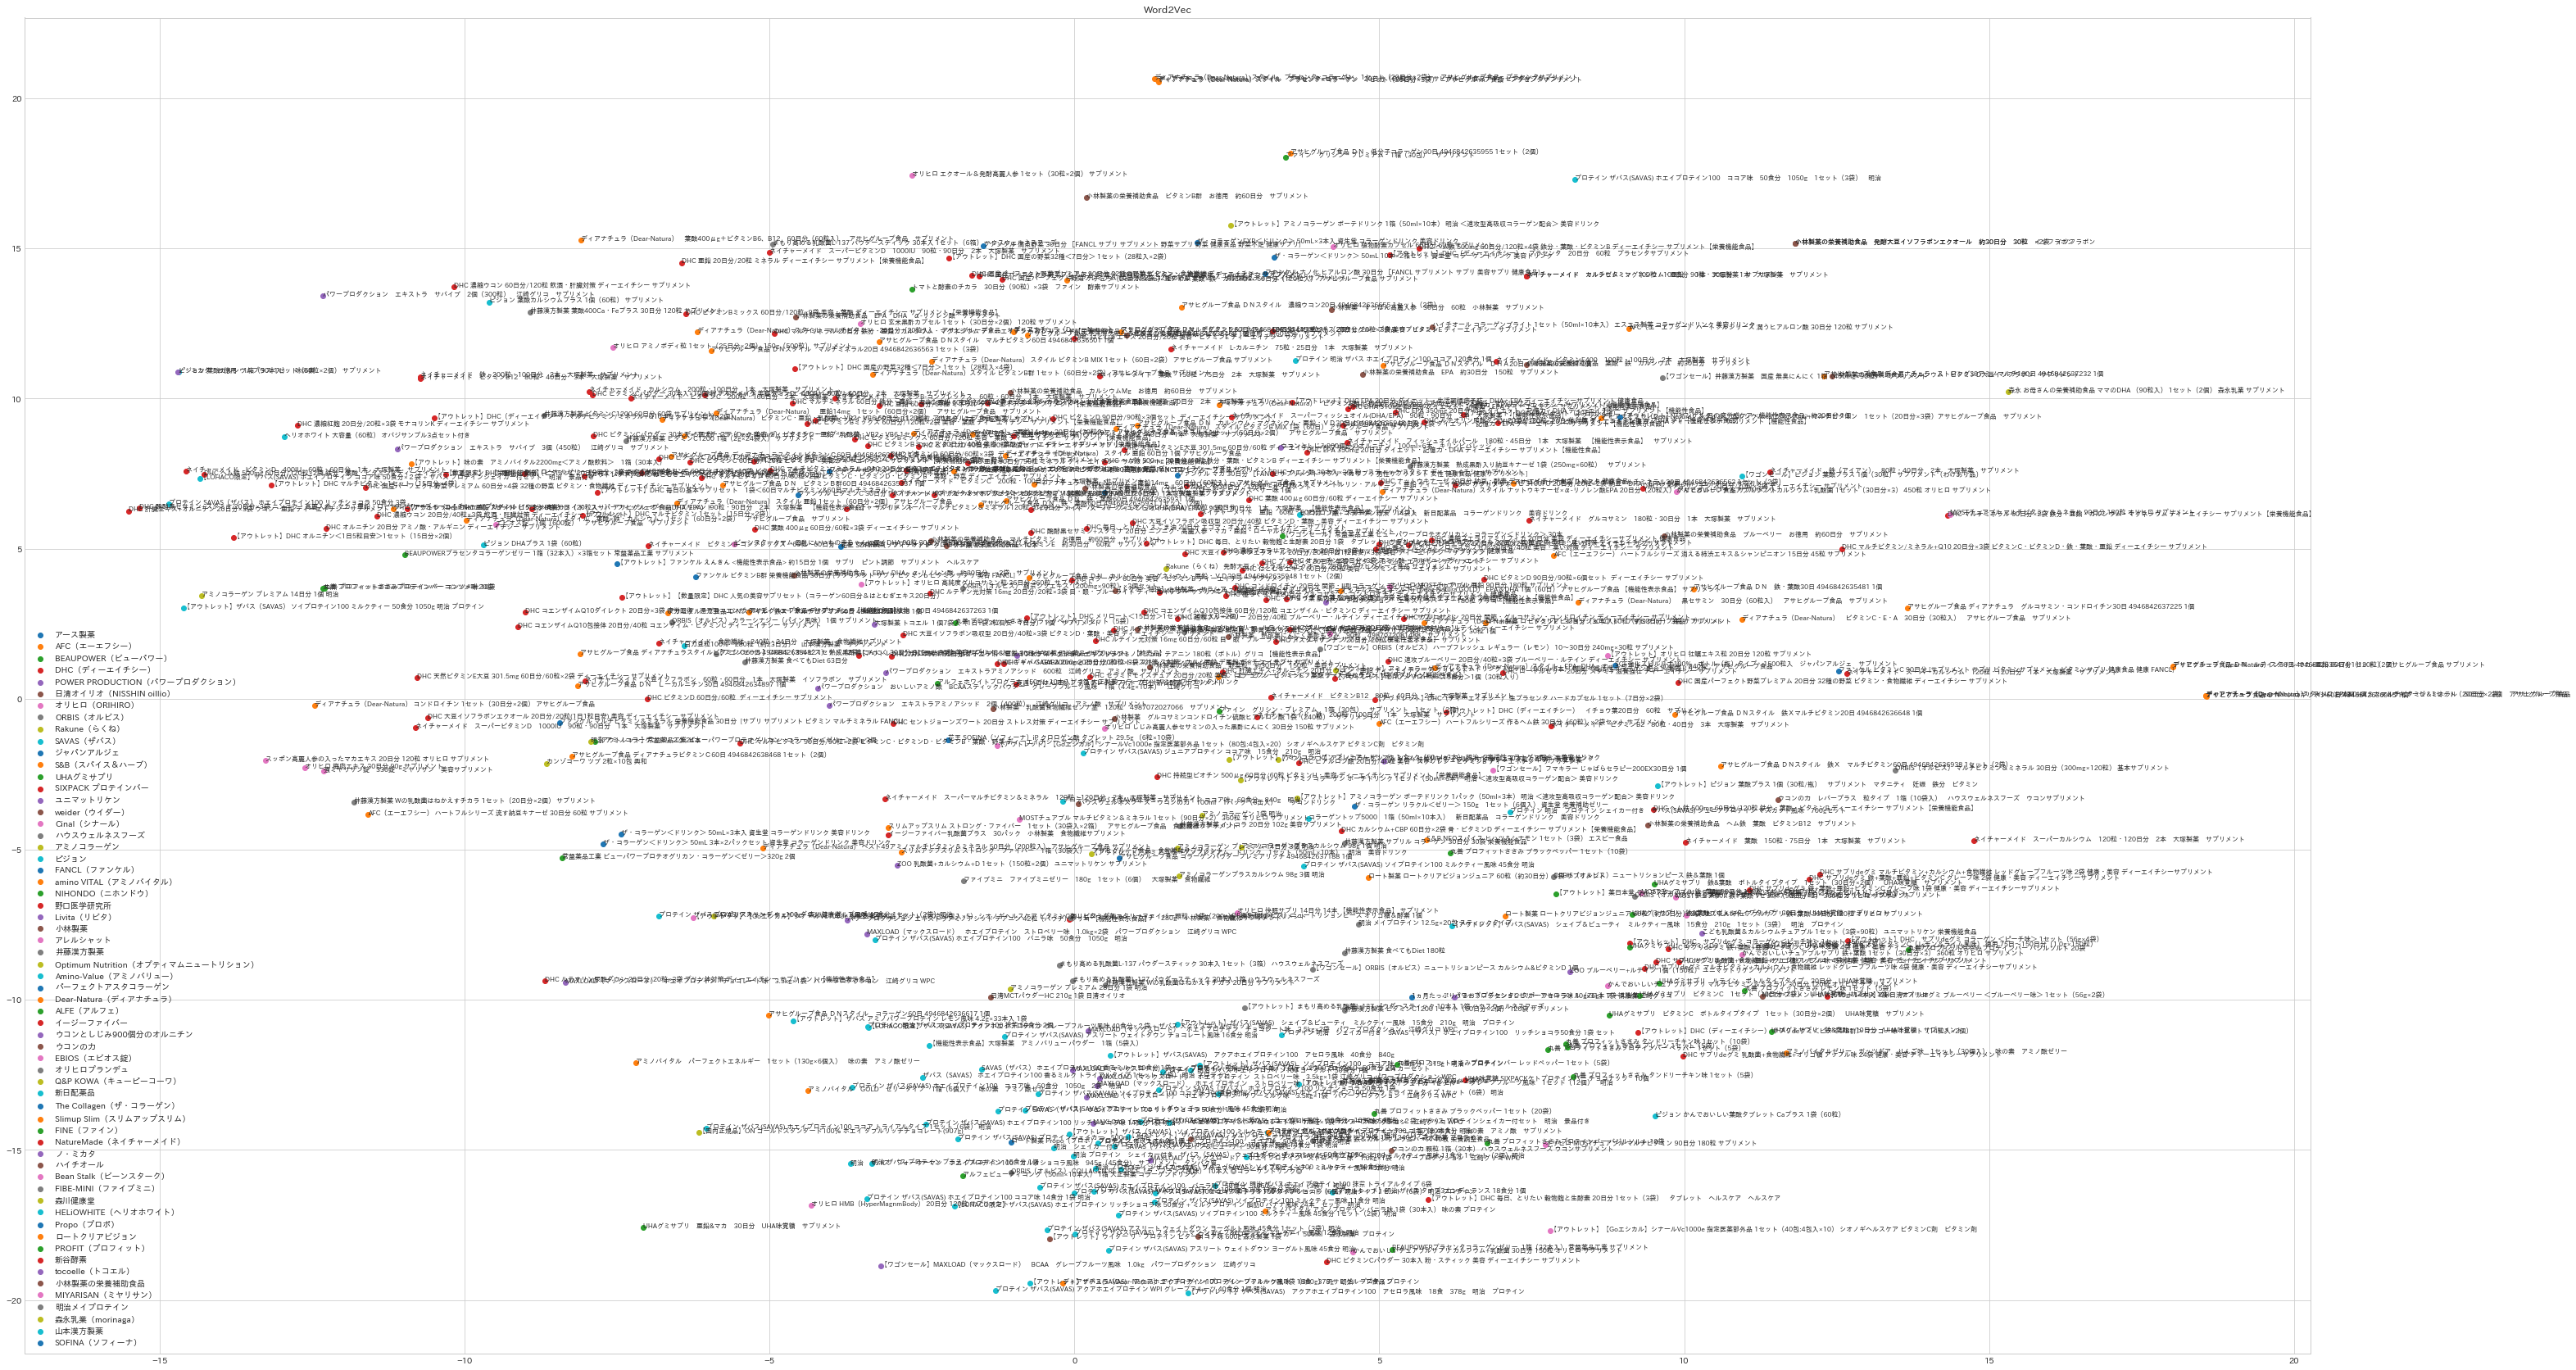

In [17]:
#Put in DataFrame
df_tsne_word2vec = pd.DataFrame(tsne_word2vec[:, 0],columns = ["x"])
df_tsne_word2vec["y"] = pd.DataFrame(tsne_word2vec[:, 1])
df_tsne_word2vec["product_name"] = df_new_combined.product_name  
df_tsne_word2vec["brand"] = df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_word2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_word2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Word2Vec-overview-")

#B: Detail
fig_detail_word2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_word2vec["product_name"].values):
    plt.annotate(txt, (df_tsne_word2vec["x"].values[i], df_tsne_word2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Word2Vec")

plt.show()

In [47]:
##Doc2Vec analysis

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora, models

trainings_combined = [TaggedDocument(words=data, tags=[name]) for (name, data) in zip(df_new_combined["product_name"], text_combined)]

# Learning model
model_doc_combined = models.Doc2Vec(
    documents=trainings_combined,
    vector_size=50,
    min_count=2,
    epochs=4000
)

In [58]:
word = "リプトン"
# Output the most similar words & similarity index
results = model_doc_combined.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


0         1        2         3        4         5         6   \
Word        トワ       温かい     イニング        一番     気に入っ        綺麗        購入   
Sim   0.535167  0.441997  0.42409  0.359616  0.35638  0.355789  0.332568   

           7         8         9         10        11        12        13  \
Word       思い       安かっ        癒さ        毎年        異国        効い      美味しく   
Sim   0.31348  0.302193  0.300955  0.299515  0.297638  0.291877  0.284169   

           14        15       16        17        18        19  
Word        母        濃く        ０      かわいい        向け        暑い  
Sim   0.28322  0.278115  0.27741  0.259111  0.250586  0.249902

In [59]:
## Plus/Minus words and show the similarities
results = model_doc_combined.wv.most_similar(positive=[u"リプトン",u"安い"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2         3         4         5         6   \
Word        香り        トワ        コス        癒さ        毎年      気に入っ        綺麗   
Sim   0.372038  0.358927  0.339417  0.338398  0.334616  0.324355  0.319897   

            7         8         9         10        11        12        13  \
Word        思い        定期        安心        購入        向け       はまっ        飲む   
Sim   0.317904  0.307789  0.302372  0.288592  0.288399  0.281103  0.277634   

            14       15        16        17       18        19  
Word      イニング    パッケージ        でる        感想       お茶         母  
Sim   0.275786  0.27345  0.260004  0.258803  0.25166  0.251638

In [61]:
## Find similar items(documents)
results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

<ipython-input-61-b771ea8573ae>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")


0                               1  \
Word  ポンパドール カモミールティー 1箱（20バッグ入）  伊藤園　ヘルシールイボスティー　500ml　1箱（24本入）   
Sim                      0.54276                        0.501323   

                                              2  \
Word  ポンパドール ハーブティーローズヒップ 1セット（60バッグ：20バッグ入×3箱）   
Sim                                    0.492985   

                                                      3  \
Word  山本漢方製薬　山本　カモミール100%　4979654024549　1箱（2g×20包）　ハ...   
Sim                                             0.47014   

                                                  4  \
Word  生活の木 私の30日茶 女性の味方ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.45922   

                                                      5  \
Word  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
Sim                                             0.45398   

                                          6  \
Word  ルピシア ハーブティー キャラメル＆ラム 1缶（50g）【ノンカフェイン】   
Sim                                 0.45277   

                                                   7  \
Word  生活の木 私の30日茶 高麗人参剛力ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.448062   

                                           8  \
Word  生活の木 ルイボスバニラモカ 1袋（40ヶ入） ハーブティー（ティーバッグ）   
Sim                                 0.440716   

                                                      9  
Word  ポンパドール ポンパドールハーブティーカモミールティー 1セット（60バッグ：20バッグ入×...  
Sim                                            0.436387

In [48]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec_doc = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.product_name[i])
    feature_vec_doc = np.zeros(50)
    num_words_doc = 0
    for word in product:
        try:
            feature_vec_doc += model_doc_combined.wv[word]
            num_words_doc += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec_doc = feature_vec_doc / num_words_doc  # Split sum of all the words vector
    product_vec_doc[i] = feature_vec_doc

##t-SNE for Doc2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_doc2vec = tsne.fit_transform(product_vec_doc)

DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　1箱（6個入）
LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートティー 1個（1.5g～2g×20袋） ハーブティー
LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー
Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）
Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）
【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン フルーツ入り ］
【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイン フルーツ入り ］
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメロン 52504 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー めぐり苺 52500 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビタカシス 52502 50g×3個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー ビューティーイチジク 52506 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー 林檎はちみつシナモン 52510 50g1個
【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティーシャンピーチ 52512 50g1個
【アウトレット】セレッシャル オーガニック カモミールラベンダー 1箱（20バッグ入）
【アウトレット】フルーツガーデン フルーツパラダイス 1袋（125g）
【ノンカフェイン】　国太楼　ルイボスティー　1袋（10

x          y                                       product_name  \
0 -45.109653  79.046638  DEAN&DELUCA（ディーンアンドデルーカ）　ティーセレクション　ハーバル&フレーバー　...   
1  12.106108   1.592252  LEBENSBAUM（レーベンスバウム） オーガニック 20種類のワールドトラベルアソートテ...   
2  17.036133  11.622809       LEBENSBAUM（レーベンスバウム） ヤノッシュシリーズ お試しセット ハーブティー   
3  24.627947  22.885389            Wismettacフーズ　セレッシャル　スリーピータイム　1箱（20バッグ入）   
4   2.782181  10.985058         Wismettacフーズ　セレッシャル　ハニーバニラカモミール　1箱（20バッグ入）   
5  -8.521563 -69.922462        Wismettacフーズ　セレッシャル　ハーブ5種アソートセット　1箱（18バッグ入）   
6 -37.420597   3.177659  【 ハーブティー 】　フルーツガーデン ストロベリークリーム 1袋 125g ［ ノンカフェ...   
7  87.071495  38.387630  【 ハーブティー 】　フルーツガーデン ハワイカクテル 1袋 125g ［ ノンカフェイン ...   
8 -68.426849  27.638330  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
9  51.686825 -58.242813  【アウトレット】VECUA Honey ハニーマルシェ 食べる果実のフルーティー すっきりメ...   

                    brand  
0               ディーン＆デルーカ  
1        SONNENTOR（ゾネントア）  
2    LEBENSBAUM（レーベンスバウム）  
3           セレッシャルシーズニングス  
4           セレッシャルシーズニングス  
5           セレッシャルシーズニングス  
6  Fruit Garden（フルーツガーデン）  
7  Fruit Garden（フルーツガーデン）  
8  Fruit Garden（フルーツガーデン）  
9    VECUA Honey（ベキュアハニー）

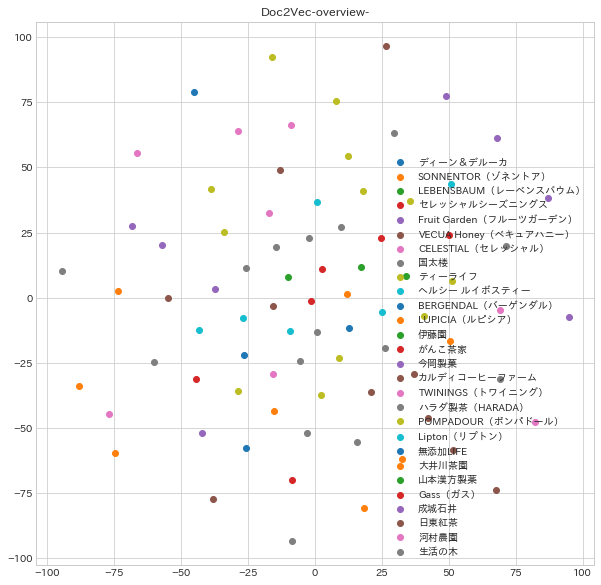

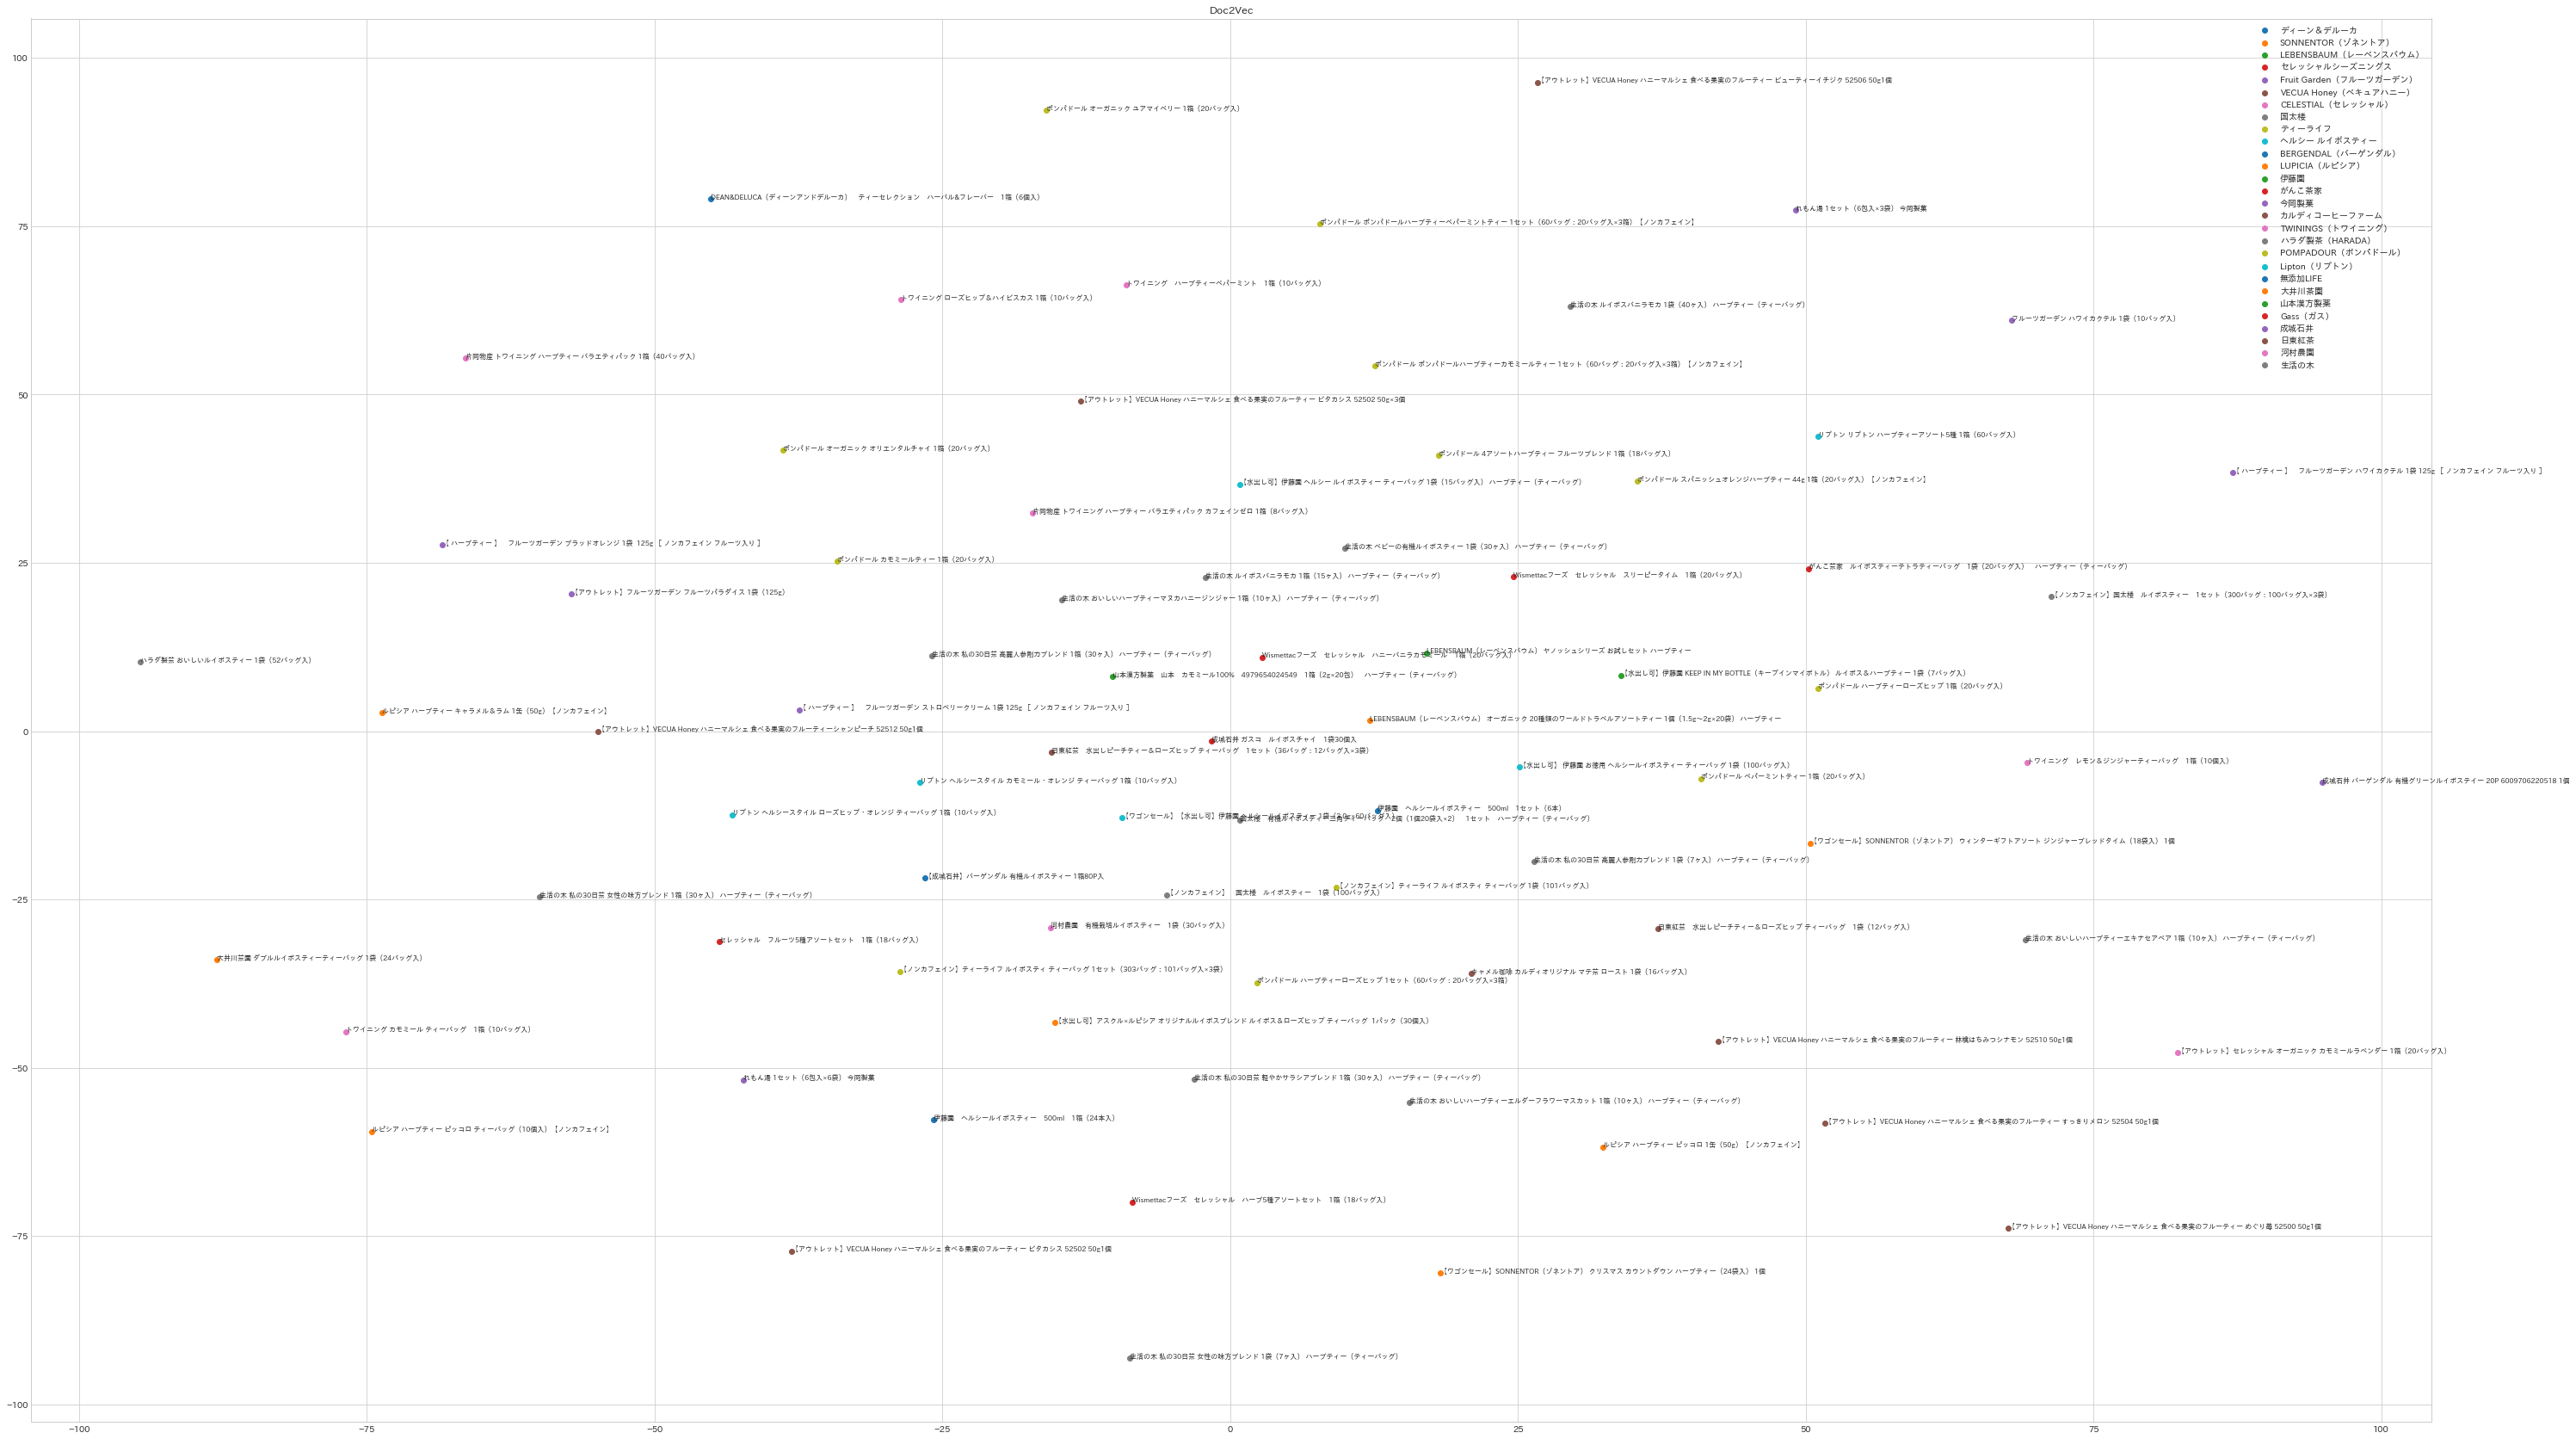

In [62]:
#Put in DataFrame
df_tsne_doc2vec = pd.DataFrame(tsne_doc2vec[:, 0],columns = ["x"])
df_tsne_doc2vec["y"] = pd.DataFrame(tsne_doc2vec[:, 1])
df_tsne_doc2vec["product_name"] = df_new_combined.product_name  
df_tsne_doc2vec["brand"] = df_new_combined.Brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_doc2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_doc2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Doc2Vec-overview-")

#B: Detail
fig_detail_doc2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_doc2vec["product_name"].values):
    plt.annotate(txt, (df_tsne_doc2vec["x"].values[i], df_tsne_doc2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Doc2Vec")

plt.show()